In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import pydiffusion
from pydiffusion import plotting

This is example notebook should teach you how to start using pydiffusion to analyze rotation diffusion of molecules from simulations.

# Generate Synthetic Trajectory

First we have to generate test data that we can analyse. For simplicity the test trajectory will only include rotations. Such a test can be generated using the rotational Brownian dynamics algorithm included in pydiffusion.

In [2]:
D = [20, 10, 5]
dt = 5e-3  # picoseconds
T = 500  # nanoseconds
niter = int(T / dt)
trj = pydiffusion.quaternionsimulation.run(D, niter, dt)

`quaternionsimulation` will return a list of quaternions that represent the orientations of our currently unspecified rigid object. We need to turn the quaternions into rotation matrices.

In [3]:
R = [pydiffusion.quaternionsimulation.quaternion_to_matrix(q) for q in trj]

This *trajectory* of rotation matrices can now be used to construct a example trajectory. As rigid body we will now use a Tetrahedron centered at the origin.

In [4]:
# Create dummy universe, needs MDAnalysis 0.17.0 or later
u = mda.Universe.empty(4, trajectory=True)
u.add_TopologyAttr('names')
u.add_TopologyAttr('resnames')
u.add_TopologyAttr('resids')
u.atoms.names = 'CA'
u.atoms.residues.resnames = 'ALA'
u.atoms.residues.resids = 1

a = 5  # edge-length
tetrahedron = u.atoms[:4]
tetrahedron[0].position = [0, 0, 0]
tetrahedron[1].position = [a, 0, 0]
tetrahedron[2].position = [a/2., np.sqrt(3)/2.*a, 0]
tetrahedron[3].position = tetrahedron[:3].centroid() + [0, 0, np.sqrt(2/3.)*a]
tetrahedron.translate(- tetrahedron.centroid())
tetrahedron.write('tetrahedron.gro')
tetrahedron = mda.Universe('tetrahedron.gro')

In [5]:
pos = tetrahedron.atoms.positions.copy()
with mda.Writer('tetrahedron.dcd', n_atoms=4) as w:
    for r in R:
        tetrahedron.atoms.positions = pos.copy()
        tetrahedron.atoms.rotate(r)
        w.write(tetrahedron)
tetrahedron.atoms.positions = pos.copy()

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


# Calculate Rotation Matrices of a Trajectory

Now that we have a trajectry to analyse we can calculate the rotation matrices.

In [6]:
u = mda.Universe('tetrahedron.gro', 'tetrahedron.dcd')
rm = pydiffusion.rotation.RotationMatrix(u.atoms, tetrahedron.atoms, verbose=True).run()

Step 100000/100000 [100.0%]


# Calculate Quaternion Covariances from Rotation Matrices

Now we have everything to calculate the quaternion covariance functions. These calculations can be expensive when evaluated for large times. Therefore we here only want the covariance function up to 5 nanosecond. To speed up the calculations we will use all available CPU resources.

In [7]:
u = pydiffusion.rotation.quaternion_covariance(rm.R, t=1000, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.3s finished


This is the full 4x4 correlation matrix. For the fitting of the diffusion coefficient the sub 3x3 matrix excluding the privileged $u_{0,0}$ will be excluded.

In [8]:
u3 = u.T[1:, 1:]

Now we can have a look at the correlations

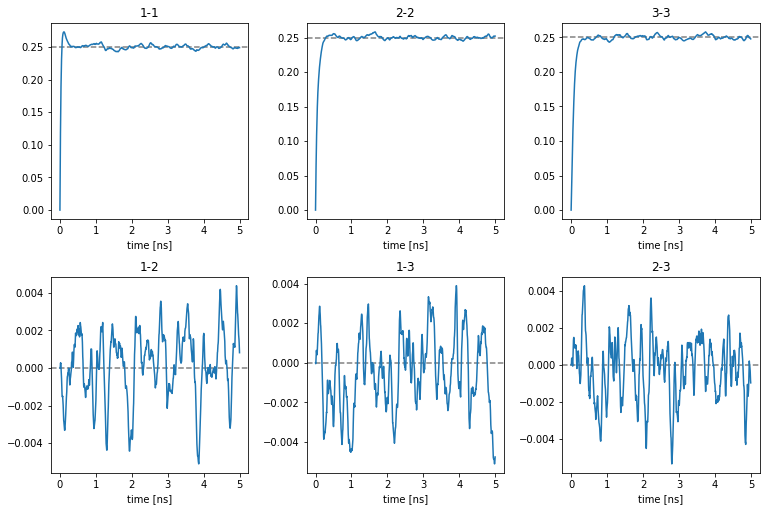

In [9]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time)
cfig.set_all_axes(xlabel='time [ns]')

cfig.tight_layout()

We can also zoom into the interesting region before the correlations are equilibratd at 1 nanosecond. Visible at the top row.

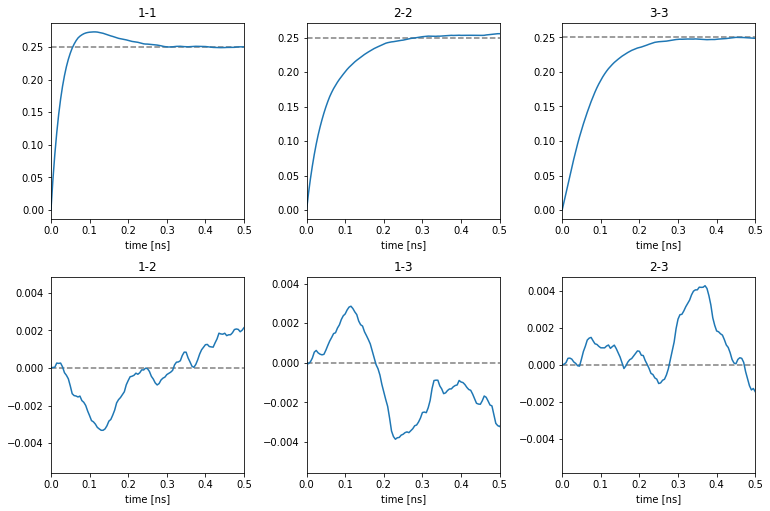

In [10]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time)
cfig.set_all_axes(xlim=(0, .5), xlabel='time [ns]')

cfig.tight_layout()

# Determine Diffusion Coefficient from Quaternion Covariances

Now we can finally fit the diffusion coefficient. Since the covariances only have interesting change that tell us about the diffusion coffiecient until 0.5 nanoseconds we will only fit up to that time.

In [11]:
tmax = .5  # nanoseconds
idx = int(tmax / dt)

res = pydiffusion.rotation.anneal(u3[:,:, :idx], time[:idx], D=[3, 2, 1], eps=0.001)
print("Diffusion coefficients = {}".format(res[0].D))
print("chi 2 = {}".format(res[1]))

Diffusion coefficients = [ 25.04455201  13.73070605   1.52269924]
chi 2 = 1.9216357570973237


This result is already quite close. But the annealing process doesn't always find the gobal minima. Therefore we will run the fit several times and later select the diffusion tensor with the smallest $\chi^2$ value.

In [12]:
res = [pydiffusion.rotation.anneal(u3[:,:, :idx], time[:idx], D=[3, 2, 1], eps=0.001) for _ in range(20)]

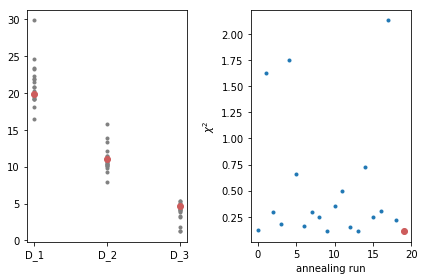

In [13]:
fig, ax = plt.subplots(ncols=2)

for r in res:
    ax[0].plot([1, 2, 3], r[0].D, '.', color='#808080')
    
score = [r[1] for r in res]
ax[1].plot(score, '.')
ax[1].set(ylabel=r'$\chi^2$', xlabel='annealing run')

argmin = np.argmin(score)
ax[0].plot([1, 2, 3], res[argmin][0].D, 'o', color='indianred')
ax[0].set(xticks=[1, 2, 3], xticklabels=['D_1', 'D_2', 'D_3'])
ax[1].plot([argmin,], score[argmin], 'o', color='indianred')

fig.tight_layout()

In [14]:
print("D optimal = {}".format(res[argmin][0].D))
print("chi2 = {}".format(res[argmin][1]))

D optimal = [ 19.92422189  11.09960821   4.63775345]
chi2 = 0.11171169023533065


In the picture you can see the spread of diffusion coefficients and in red the optimal choice that we picked.

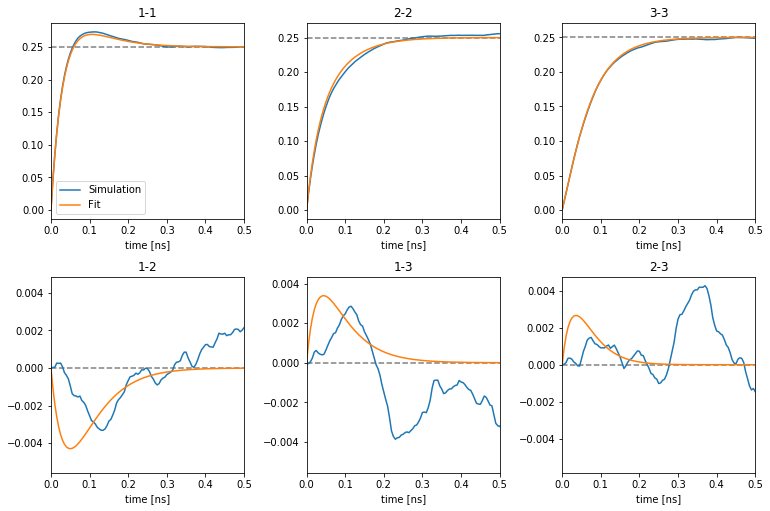

In [15]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time, label='Simulation')
plotting.plot_model(res[argmin][0], time, label='Fit', covfig=cfig)
cfig.set_all_axes(xlim=(0, .5), xlabel='time [ns]')
cfig.axes[0, 0].legend()

cfig.tight_layout()